# 1. 데이터: 기상 데이터 다운로드
- 기상 정보에 관한 데이터 셋
- 현재 시점에서의 기상 상태를 나타내는 총 14개의 독립변수를 갖고 있음
- 24시간 후의 기온(섭씨)를 예측하는 것이 목적

In [ ]:
!git clone https://github.com/kc9410/Model_Evaluation.git

In [9]:
import numpy as np
import pandas as pd
data = pd.read_csv('/content/Model_Evaluation/data/weather_dataset.csv')

In [2]:
data.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [3]:
#10분 단위로 측정된 시계열 데이터 셋
data.loc[:10,'Date Time']

0     01.01.2009 00:10:00
1     01.01.2009 00:20:00
2     01.01.2009 00:30:00
3     01.01.2009 00:40:00
4     01.01.2009 00:50:00
5     01.01.2009 01:00:00
6     01.01.2009 01:10:00
7     01.01.2009 01:20:00
8     01.01.2009 01:30:00
9     01.01.2009 01:40:00
10    01.01.2009 01:50:00
Name: Date Time, dtype: object

In [4]:
# Label 분리 및 불필요한 변수 제거
labels = data.loc[:,'T (degC)']
using_data = data.drop('Date Time',axis=1)

In [5]:
float_data = np.array(using_data)

# 2. Data Split
- 데이터를 나눌 때 시계열 데이터는 주의해야 함
- 무작위 추출 방식을 사용할 경우, 미래 정보를 활용하여 과거를 예측하는 오류를 범할 수 있음

In [6]:
#10분*144 = 24시간
idx = np.arange(float_data.shape[0]-144)

#Train:Test = 8:2
tr_ratio = 0.8 
tr_point = int(len(idx)*tr_ratio)

train_idx = idx[0:tr_point]
test_idx = idx[tr_point:]

In [7]:
X_train = float_data[train_idx]
y_train = labels[train_idx+144]

X_test = float_data[test_idx]
y_test = labels[test_idx+144]

In [8]:
# train 데이터를 기반으로 train/test 데이터에 대하여 standard scaling 적용 (평균 0, 분산 1) 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(X_train)

In [9]:
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

# 3. 모델 학습

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [11]:
line_fitter = LinearRegression()
line_fitter.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
ranfo_fitter = RandomForestRegressor(n_estimators=50,n_jobs=-1,max_depth=10)
ranfo_fitter.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# 4-1. 선형 회귀 모델 평가

In [13]:
import matplotlib.pyplot as plt

In [14]:
pred_train = line_fitter.predict(X_train)
pred_test = line_fitter.predict(X_test)

In [15]:
def MAE(pred,real) :
    return round(np.mean(np.abs(pred-real)),3)
def MAPE(pred,real) :
    return round(np.mean(np.abs((pred-real)/(real+1e-10)))*100,1)

In [16]:
print("MAE_train:", MAE(pred_train,y_train))
print("MAE_test:", MAE(pred_test,y_test))
print("MAPE_train:", MAPE(pred_train,y_train),"%")
print("MAPE_test:", MAPE(pred_test,y_test),"%")

MAE_train: 2.425
MAE_test: 2.918
MAPE_train: 1036475820.1 %
MAPE_test: 32.5 %


In [17]:
time_idx = y_train.index
result_df = pd.DataFrame([time_idx,pred_train,y_train]).transpose()

In [18]:
result_df.columns = ['time','pred','real']
result_df[:10]

,time,pred,real
0,144.0,-6.375548,-4.60
1,145.0,-6.938994,-4.67
2,146.0,-6.884217,-4.66
3,147.0,-6.798294,-4.55
4,148.0,-6.583603,-4.43
5,149.0,-6.686238,-4.44
6,150.0,-6.421936,-4.39
7,151.0,-6.150801,-4.40
8,152.0,-6.631742,-4.40
9,153.0,-6.766439,-4.31


In [19]:
result_df =result_df.sort_values(by='time')

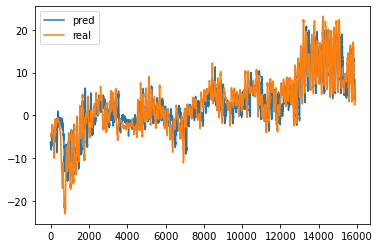

In [20]:
plt.plot(result_df.pred,label='pred')
plt.plot(result_df.real,label='real')
plt.legend()

In [21]:
time_idx = y_test.index
result_df = pd.DataFrame([time_idx,pred_test,y_test]).transpose()

In [22]:
result_df.columns = ['time','pred','real']
result_df[:10]
result_df =result_df.sort_values(by='time')

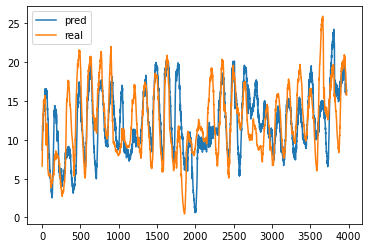

In [23]:
plt.plot(result_df.pred,label='pred')
plt.plot(result_df.real,label='real')
plt.legend()

# 4-2. 랜덤 포레스트 모델 평가

In [24]:
pred_train = ranfo_fitter.predict(X_train)
pred_test = ranfo_fitter.predict(X_test)

In [25]:
print("MAE_train:", MAE(pred_train,y_train))
print("MAE_test:", MAE(pred_test,y_test))
print("MAPE_train:", MAPE(pred_train,y_train),"%")
print("MAPE_test:", MAPE(pred_test,y_test),"%")

MAE_train: 1.016
MAE_test: 3.105
MAPE_train: 646197443.9 %
MAPE_test: 32.8 %


In [26]:
time_idx = y_train.index
result_df = pd.DataFrame([time_idx,pred_train,y_train]).transpose()
result_df.columns = ['time','pred','real']
result_df =result_df.sort_values(by='time')

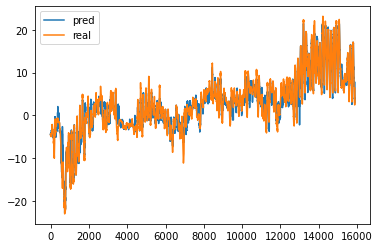

In [27]:
plt.plot(result_df.pred,label='pred')
plt.plot(result_df.real,label='real')
plt.legend()

In [28]:
time_idx = y_test.index
result_df = pd.DataFrame([time_idx,pred_test,y_test]).transpose()
result_df.columns = ['time','pred','real']
result_df =result_df.sort_values(by='time')

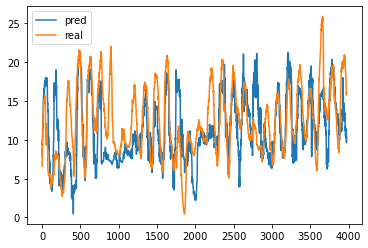

In [29]:
plt.plot(result_df.pred,label='pred')
plt.plot(result_df.real,label='real')
plt.legend()